![LaTex: Quadratic Functions](3DTechLogo.png)

<font size="3"><div style="text-align: justify"> **Predictive Maintenance** has a long history. From visual inspection, which is the oldest method and still one of the most
powerful and widely used, predictive maintenance has evolved to automated methods that use advanced signal processing techniques
based on pattern recognition, including neural networks,fuzzy logic, and data-driven empirical and physical modeling. Fortunately, sensors are now available to identify the onset of equipment degradations and failures. Integrating these sensors with the predictive maintenance techniques can avoid unnecessary equipment replacement, save costs, and improve process safety, availability, and efficiency  <cite data-cite="hashemian2010state">(hashemian, 2010).</cite> </div></font>

<font size="3"><div style="text-align: justify">AWS has a machine learning solution for Predictive Maintenance challenge, click on this link for more information [AWS predictive maintenace](https://aws.amazon.com/solutions/predictive-maintenance-using-machine-learning).</div></font>

# Loading packages 

<font size="3"><div style="text-align: justify">  In this section, the packages to process, analyze and visualize the data are loaded. Among these we can find: pandas,numpy, seaborn, scipy, matplotlib  and others. In addition, xgboost, sklearn and imblearn are loaded to fit the machine learning model.</div></font>


In [1]:
from functions.main_functions import upload_csv, plot_curve_roc

In [2]:
import warnings, pypandoc, random
import os
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np 
from datetime import datetime
import seaborn as sns
from xgboost import XGBClassifier
get_ipython().run_line_magic('matplotlib', 'inline')
from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from collections import Counter 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn import svm
import imblearn
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


# Data

<font size="3"><div style="text-align: justify">The database has 124494 rows, there is a total of 1169 unique devices of which 106 have had failures. The data has the daily report date, the failure/ non-failure column, recorded as 0 or 1, and 9 attributes related to the device. The information belongs to the period between 2015-01-01 and 2015-11-02. Additionally, the number of days from the first-day report is also included as a feature. </div></font>

<font size="3"><div style="text-align: justify"> </div></font>
![LaTex: Q](summay_data.png)

In [3]:
data_path = 'C:/Users/vivi/Documents/AWS/project/data/'
file = 'device_failure.csv'
df = upload_csv(data_path, file)

In [4]:
print(df.shape)
df.head()

(124494, 14)


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,date_time,day
0,2015-01-01,S1F01085,0.0,215630672.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0,2015-01-01,0
1163,2015-01-02,S1F01085,0.0,1650864.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0,2015-01-02,1
2326,2015-01-03,S1F01085,0.0,124017368.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0,2015-01-03,2
3489,2015-01-04,S1F01085,0.0,128073224.0,56.0,0.0,52.0,6.0,407439.0,0.0,0.0,7.0,2015-01-04,3
4651,2015-01-05,S1F01085,0.0,97393448.0,56.0,0.0,52.0,6.0,408114.0,0.0,0.0,7.0,2015-01-05,4


In [5]:
device = df['device'].drop_duplicates()
print('Total number of unique devices:',device.shape[0])
fail_devices = list(df[df['failure']==1.0]['device'].drop_duplicates())
print('Total number of failure:',len(fail_devices))
no_fail_devices = list(set(list(df['device'].drop_duplicates()))-set(fail_devices))
print('Total number of non-failure:', len(no_fail_devices))

Total number of unique devices: 1169
Total number of failure: 106
Total number of non-failure: 1063


In [6]:
print('Minimum date:',min(df['date']))
print('Maxiimum date:',max(df['date']))

Minimum date: 2015-01-01
Maxiimum date: 2015-11-02


# Exploratory Data Analysis

<font size="3"><div style="text-align: justify">The descriptive statistics and the boxplots are calculated for the 9 attributes in the dataset. It can be appreciated that Attribute 1 has the highest variance and the highest mean in the data but it does not have outliers. Variables 2 to 9 have many outlier values in the distribution. There is no visible difference in the failure/ non-failure attribute for any of the features regarded, which seems to indicate that new features need to be considered to enhance the classification model; nevertheless, the interactions of the variables must be included in the model to be able to conclude this. The above will be assessed in the fitting model section.</div></font>

In [7]:
varx=['attribute1','attribute2','attribute3','attribute4','attribute5','attribute6',
        'attribute7','attribute8','attribute9','day']
df[varx].describe()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,day
count,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524,102.178675
std,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623,77.211274
min,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000,37.000000
50%,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000,82.000000
75%,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000,161.000000
max,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000,303.000000


In [8]:
#import pandas as pd
df2 = pd.melt(df, id_vars=['date', 'device','failure'], 
              value_vars=['attribute1','attribute2','attribute3',
                            'attribute4','attribute5','attribute6',
                            'attribute7','attribute8','attribute9'])

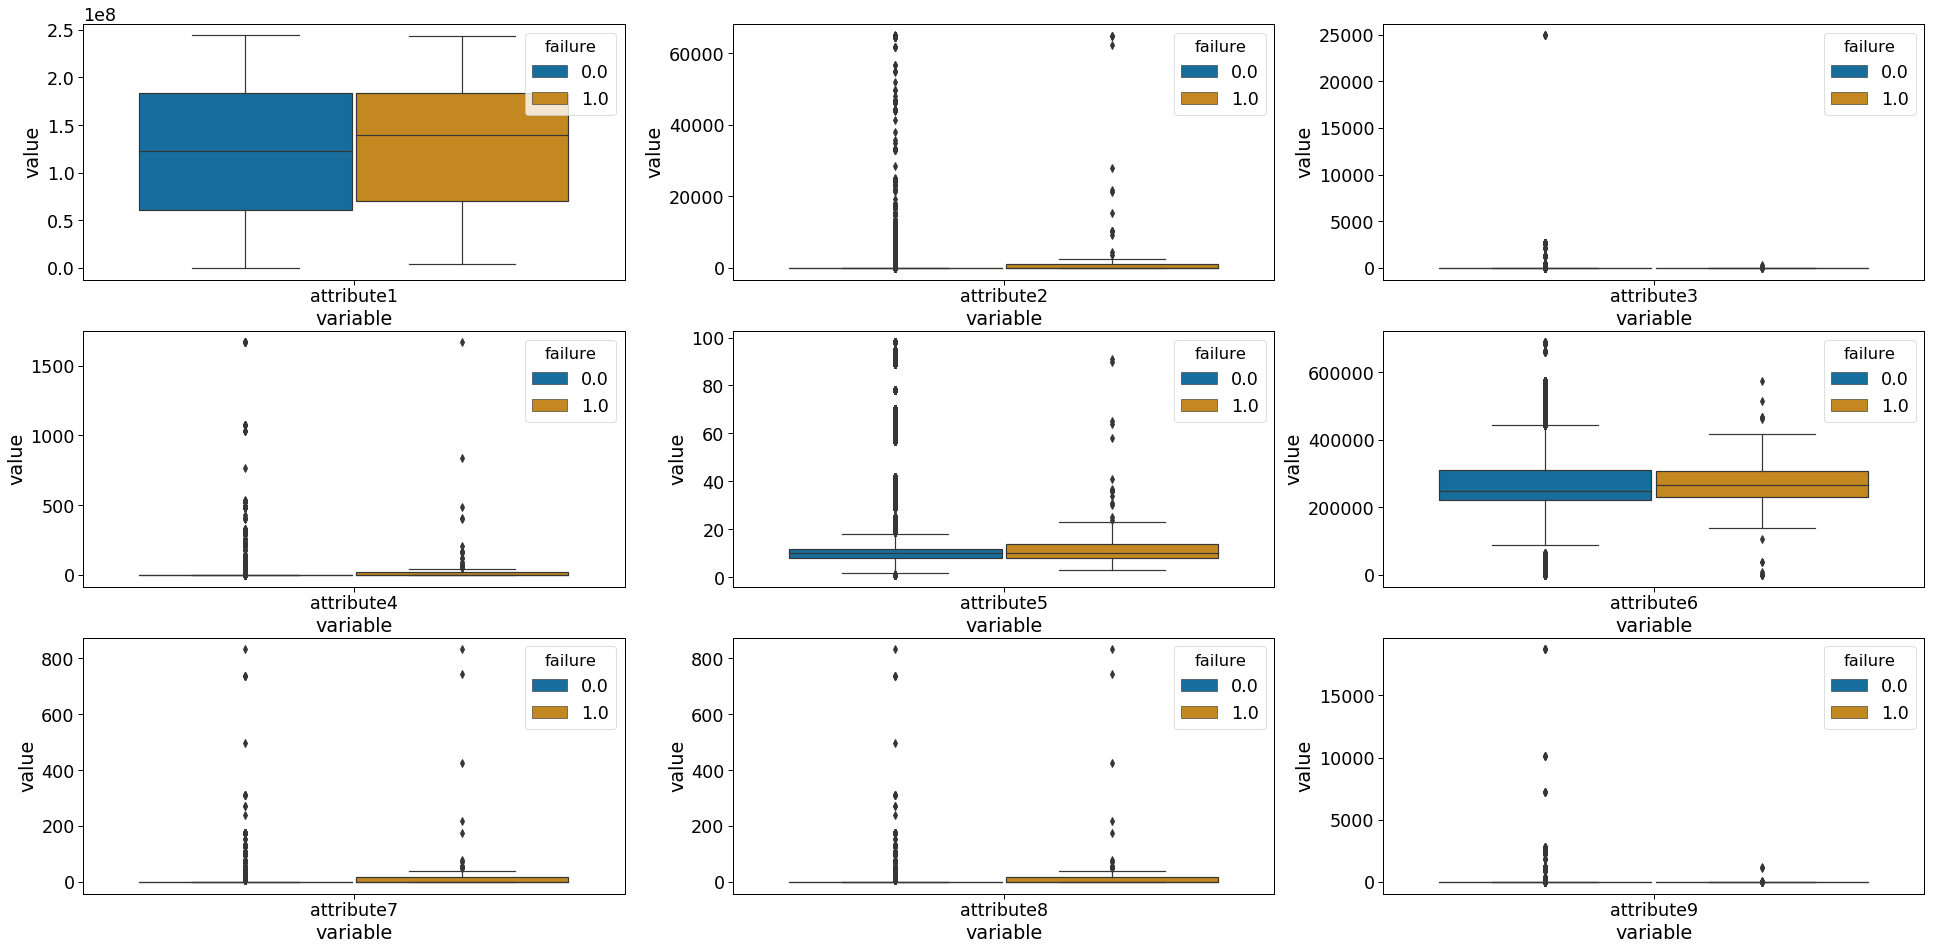

In [9]:
sns.set_context("paper", font_scale=2)
fig = plt.figure(figsize=(33, 16))
ax1 =fig.add_subplot(3,3,1)
sns.boxplot(x = 'variable', y = 'value',
                 data=df2[df2['variable'].isin(['attribute1'])], hue = 'failure',
                 palette="colorblind")
ax2 =fig.add_subplot(3,3,2)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df2[df2['variable'].isin(['attribute2'])], hue = 'failure',
                 palette="colorblind")
ax3 =fig.add_subplot(3,3,3)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df2[df2['variable'].isin(['attribute3'])], hue = 'failure',
                 palette="colorblind")

ax4 =fig.add_subplot(3,3,4)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df2[df2['variable'].isin(['attribute4'])], hue = 'failure',
                 palette="colorblind")
ax5 =fig.add_subplot(3,3,5)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df2[df2['variable'].isin(['attribute5'])],
                 hue = 'failure',palette="colorblind")
ax6 =fig.add_subplot(3,3,6)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df2[df2['variable'].isin(['attribute6'])], hue = 'failure',
                 palette="colorblind")
ax7 =fig.add_subplot(3,3,7)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df2[df2['variable'].isin(['attribute7'])], hue = 'failure',
                 palette="colorblind")
ax8 =fig.add_subplot(3,3,8)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df2[df2['variable'].isin(['attribute8'])], hue = 'failure',
                 palette="colorblind")
ax9 =fig.add_subplot(3,3,9)
sns.boxplot(x = 'variable', y = 'value', 
                 data=df2[df2['variable'].isin(['attribute9'])], hue = 'failure',
                 palette="colorblind")
plt.savefig('books_read.png')

# Methodology

<font size="3"><div style="text-align: justify"> There are two key points in this challenge. First, this an imbalanced dataset that could bias the model to classify the observations as part of the majority class. Second, this is a repeated measurements dataset which means we have autocorrelation, as it is well known, one of the strongest assumption in Machine Learning models is that data is independent and identically distributed. Therefore, these issues have to be considered during the fitting process.</div></font>

<font size="3"><div style="text-align: justify"> 
A binary classification model can be used to predict the probability of a device failure. This notebook presents a way to handle the dependency on data, the imbalanced classes, three different machine learning classification models, a cross-validation process to test the dependency of the results on the fitted model and the sample used to train its as weel as a grid search process to optimize the hyperparameters in the best performed model.</div></font>

## Independent data sets for training and testing

<font size="3"><div style="text-align: justify">
A central assumption in Machine Learning (and statistics) it that of independent and identically distributed (IID) data. The readouts consist of aggregated data that have been sampled at different times. Subsequent values from any given device are highly correlated to each other. It is even more evident in the case of cumulative values where a single event of
abnormal value will directly affect all subsequent readouts which makes all readouts from a single device dependent.</div></font>    
<font size="3"><div style="text-align: justify"> A partial way to deal with this problem is to ensure that the test and train dataset is split on a per device basis and not randomly among all readouts. It means that if one
or more readouts from a given device belong to the test set, no readouts from the same
device can be used to train the classifier. The data sets for training and testing must
contain unique, non-overlapping sets of devices to guarantee that patterns
that are linked to wear and usage are learned, instead of specific usage patterns for
individual devices.<cite data-cite="prytz2013analysis">(prytz,2013).</cite></div></font>

<font size="3"><div style="text-align: justify">Regarding the unique devices, the dataset is split in training and test taking in account the failure/ no-failure dependente variable. </div></font>

In [10]:
df=pd.read_csv(os.path.join(data_path,'device_failure_dataframe.csv'))


In [11]:
device = df['device'].drop_duplicates()
print('Total number of unique devices:',device.shape[0])
fail_devices = list(df[df['failure']==1.0]['device'].drop_duplicates())
print('Total number of failure:',len(fail_devices))
no_fail_devices = list(set(df['device'].drop_duplicates()).difference(fail_devices))
print('Total number of non-failure:', len(no_fail_devices))

Total number of unique devices: 1169
Total number of failure: 106
Total number of non-failure: 1063


In [12]:
y_fail = list(np.repeat(1,len(fail_devices)))+list(np.repeat(0,len(no_fail_devices)))
X_fail = fail_devices +  no_fail_devices

In [13]:
X_trainf, X_testf, y_trainf, y_testf = train_test_split(X_fail, y_fail, test_size=0.25, random_state=42,stratify=y_fail)

In [14]:
var = ['attribute1','attribute2','attribute3','attribute4','attribute5',
         'attribute6','attribute7','attribute8','attribute9']
train = df[df['device'].isin(X_trainf)]
X_train = train[var]
y_train = train['failure']

test = df[df['device'].isin(X_testf)]
X_test = test[var]
y_test = test['failure']

In [15]:
X_test.to_csv(os.path.join(data_path,'X_test.csv'))
y_test.to_csv(os.path.join(data_path,'y_test.csv'))

In [16]:
print(Counter(y_trainf))
print(Counter(y_testf))

Counter({0: 797, 1: 79})
Counter({0: 266, 1: 27})


In [17]:
print(74/(774+74)*100)
print((32/(32+319))*100)

8.726415094339622
9.116809116809117


## Balancing the dataset

<font size="3"><div style="text-align: justify">Machine learning methods usually assume a fairly balanced data distribution when an imbalanced dataset is used to train a model the results tend to be heavily biased towards the majority class. This is the case faced here, there is a small proportion of failed devices. </div></font>

<font size="3"><div style="text-align: justify">
Imbalanced datasets require either learning algorithms that handle this or data preprocessing steps that even out the imbalance. Upsampling and downsampling are techniques to preproccess the data; however, there is not an agreement about the percentage that should be used to have better results during the balance process. In consecuence, the Synthetic Minority Over-sampling TEchnique (SMOTE) introduced by <cite data-cite="chawla2002smote">(chawla,2002).</cite> is used. 
 </div></font>
   
<font size="3"><div style="text-align: justify"> SMOTE technique identifies, for any given positive example, the k nearest neighbours belonging to the same class. It then creates new, synthetic, examples randomly placed in between the original example and the k neighbors. It uses two design parameters: number of neighbors to take into consideration (k) and the percentage of
synthetic examples to create. The first parameter, intuitively, determines how similar new examples should be to existing ones, and the other how balanced the data should be afterward. <cite data-cite="prytz2013analysis">(prytz,2013).</cite> </div></font>


In [18]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=42)
X_trainup, y_trainup = oversample.fit_resample(X_train, y_train)

In [19]:
#X_trainup.to_csv(os.path.join(data_path,'X_trainup.csv'))
#y_trainup.to_csv(os.path.join(data_path,'y_trainup.csv'))

## Fitted  Models

<font size="3"><div style="text-align: left"> Three models are observed in the fitting model process:</div></font>

<font size="3"><div style="text-align: left">    
* Random Forest [Random Forest introduction](https://medium.com/@Synced/how-random-forest-algorithm-works-in-machine-learning-3c0fe15b6674)
* KNeighbors model [KNeighbors model introduction](https://medium.com/datadriveninvestor/k-nearest-neighbors-knn-7b4bd0128da7)
* XgBoost [Xgboost introduction](https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5)   
</div></font>

<font size="3"><div style="text-align: left"> 
The model with the best performance is tunned by means of a grid search process and the cross-validation process is used to assess this model.</div></font>  

<font size="3"><div style="text-align: left"> 
Four metrics are calculated for each one of the models estimated: accuracy, F1-score, recall, precision. Even though, **given that the goal of the analysis is to minimize false positives and false negatives, the F1 score is considered as the metric to maximize**. [Evaluation metrics](https://medium.com/@kennymiyasato/classification-report-precision-recall-f1-score-accuracy-16a245a437a5)
</div></font>  

In [20]:
X_trainup = pd.read_csv(os.path.join(data_path,'X_trainup.csv')).drop(columns=['Unnamed: 0'])
y_trainup = pd.read_csv(os.path.join(data_path,'y_trainup.csv')).drop(columns=['Unnamed: 0'])

### Random Forest 

In [21]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(X_trainup, y_trainup)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

#### Feature importance

In [22]:
pd.DataFrame({'var':X_trainup.columns,'feature_importance':clf.feature_importances_}).sort_values(['feature_importance'],ascending=False)

,var,feature_importance
3,attribute4,0.332248
1,attribute2,0.292423
7,attribute8,0.167746
6,attribute7,0.165769
8,attribute9,0.025127
4,attribute5,0.009661
5,attribute6,0.004788
2,attribute3,0.001164
0,attribute1,0.001072


In [23]:
predictions=clf.predict(X_test)
confusion_matrix(y_test, predictions)

array([[26370,   860],
       [    9,    18]], dtype=int64)

In [24]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.3f" % (accuracy))
auc = roc_auc_score(y_test, predictions)
print("AUC: %.3f" % (auc))
F1=f1_score(y_test, predictions)
print("F1-score: %.3f" % (F1))
recall = recall_score(y_test, predictions)
print("recall: %.3f" % (recall))
precision = precision_score(y_test, predictions)
print("precision: %.3f" % (precision))

Accuracy: 0.968
AUC: 0.818
F1-score: 0.040
recall: 0.667
precision: 0.021


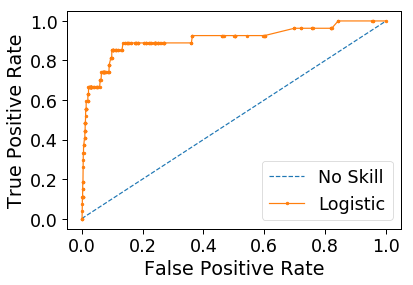

In [25]:
plot_curve_roc(clf,X_test,y_test)

### KNeighbors model 

In [26]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_trainup, y_trainup)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [27]:
predictions = neigh.predict(X_test)
confusion_matrix(y_test, predictions)

array([[23343,  3887],
       [   21,     6]], dtype=int64)

In [28]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.3f" % (accuracy ))
auc = roc_auc_score(y_test, predictions)
print("AUC: %.3f" % (auc))
F1=f1_score(y_test, predictions)
print("F1-score: %.3f" % (F1))
recall = recall_score(y_test, predictions)
print("recall: %.3f" % (recall))
precision = precision_score(y_test, predictions)
print("precision: %.3f" % (precision))

Accuracy: 0.857
AUC: 0.540
F1-score: 0.003
recall: 0.222
precision: 0.002


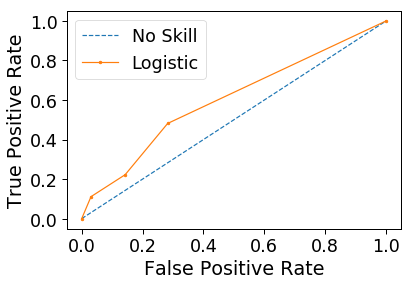

In [29]:
plot_curve_roc(neigh,X_test,y_test)

### XGBoost model

In [30]:
model = XGBClassifier(random_state=0)

In [31]:
model.fit(X_trainup, y_trainup)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [32]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [33]:
confusion_matrix(y_test, predictions)

array([[27159,    71],
       [   23,     4]], dtype=int64)

In [34]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.3f" % (accuracy))
auc = roc_auc_score(y_test, predictions)
print("AUC: %.3f" % (auc))
F1=f1_score(y_test, predictions)
print("F1-score: %.3f" % (F1))
recall = recall_score(y_test, predictions)
print("recall: %.3f" % (recall ))
precision = precision_score(y_test, predictions)
print("precision: %.3f" % (precision))

Accuracy: 0.997
AUC: 0.573
F1-score: 0.078
recall: 0.148
precision: 0.053


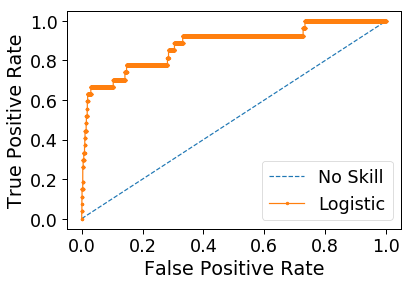

In [35]:
plot_curve_roc(model,X_test,y_test)

## Gridsearch and Cross-validation

<font size="3"><div style="text-align: justify">XGBoost model had the best performance between the considered models with a F1-score equal to 0.078. The remaining models did not have a good performance regarding the evaluation metric. However, this is not a good fitting result to use this model to predict.</div></font>  
<font size="3"><div style="text-align: justify"> The cross-validation and grid search processes are often used to evaluate the dependency between the results and the sample used to fit the model and to optimize the hyperparameters in the model definition, respectively. Both techniques were executed in Sagemaker; nonetheless, given the low representativity in the minority class, there is a high variability in the cross-validation results trough the different folds. Added to this, the fitting model using the optimized parameters found in the grid search execution does not enhance the f1-score performance; it is important to bear in mind that there is a cross-validation process immersed in this technique which can affect the results given the imbalanced classes.</div></font>

### Cross-validation

In [36]:
clf_xgb = XGBClassifier(objective = 'binary:logistic')
varx=['attribute1','attribute2','attribute3','attribute4',
        'attribute5','attribute6','attribute7','attribute8',
        'attribute9','day']


numFolds = 10
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_fail, y_fail)

i=0
for train_index, test_index in skf.split(X_fail, y_fail):
    i = i+1
    print(i)
    X_train, X_test = df[df['device'].isin([X_fail[j] for j in train_index])][varx], df[df['device'].isin([X_fail[j] for j in test_index])][varx]
    y_train, y_test = df[df['device'].isin([X_fail[j] for j in train_index])]['failure'], df[df['device'].isin([X_fail[j] for j in test_index])]['failure']
    oversample = SMOTE()
    X_trainup, y_trainup = oversample.fit_resample(X_train, y_train)
    clf_xgb.fit(X_trainup, y_trainup)
    
    y_pred = clf_xgb.predict(X_test)
    predictions = [round(value) for value in y_pred]
    print(confusion_matrix(y_test, predictions))
    score1 = f1_score(y_test, predictions)
    print(score1)  

1
[[26966   147]
 [   18     4]]
0.046242774566473986
2
[[24170   159]
 [   15     6]]
0.06451612903225805
3
[[24472    87]
 [   16     5]]
0.08849557522123892
4
[[23946   349]
 [   18     3]]
0.016085790884718495
5
[[24023    69]
 [   18     3]]
0.06451612903225806


In [41]:
print("Mean F1-score for cross-valiation: %.4f" % ((0.04+0.06+0.08+0.+0.01+0.06)/5))

Mean F1-score for cross-valiation: 0.0500


### Gridsearch

In [41]:
from sklearn.metrics import f1_score
clf_xgb = XGBClassifier(objective = 'binary:logistic')
from sklearn.metrics import fbeta_score, make_scorer
f1_scorer = make_scorer(f1_score)
param_dist = {'n_estimators': [100,200,300],
              'learning_rate': [0.2,0.3,0.4],
              'max_depth': [5, 6, 7]}

clf =  GridSearchCV(clf_xgb, param_grid = param_dist, cv=2, scoring = 'accuracy',verbose=10)
clf.fit(X_trainup, list(y_trainup))

In [69]:
clf.best_score_, clf.best_params_

(0.981839082884232,
 {'learning_rate': 0.4, 'max_depth': 6, 'n_estimators': 300})

In [38]:
#learning_rate = 0.3, max_depth= 5, n_estimators= 300
model_tunned = XGBClassifier(learning_rate = 0.4, max_depth= 6, n_estimators= 300,random_state=0)
model_tunned.fit(X_trainup, y_trainup)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.4, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [39]:
y_pred_tunned = model_tunned.predict(X_test)
predictions_tunned = [round(value) for value in y_pred_tunned]
confusion_matrix(y_test, predictions_tunned)

array([[24018,    74],
       [   18,     3]], dtype=int64)

In [40]:
accuracy = accuracy_score(y_test, predictions_tunned)
print("Accuracy: %.2f" % (accuracy ))
auc = roc_auc_score(y_test, predictions_tunned)
print("AUC: %.2f" % (auc))
F1=f1_score(y_test, predictions_tunned)
print("F1-score: %.3f" % (F1 ))
recall = recall_score(y_test, predictions_tunned)
print("recall: %.2f" % (recall))
precision = precision_score(y_test, predictions_tunned)
print("precision: %.2f" % (precision))

Accuracy: 1.00
AUC: 0.57
F1-score: 0.061
recall: 0.14
precision: 0.04


# Results

<font size="3"><div style="text-align: justify"> The dataset has an imbalanced distribution in the classes; to handle this, a Smote technique was executed to balance it. After a brief EDA process, a weak visual relation between the features and the dependent variable was identified. In the methodology section, the XGboost model was the one with the best performance; however, it just achieved an f1-score equal to 0.123 which is not good enough for using this model for the prediction task. </div></font>

<font size="3"><div style="text-align: left">   
To enhance the results of the model three strategies can be developed:
    
1. Consider new features or add new information to the dataset, such as device photos or a brief description of the device status
    given by the analyst.
    
2. Gather more device recordings to increase the dataset size, probably, the features already used can help to classified the
    data in the right way but as we do not have much information about failed device behavior, the model is not able to
    identify clearly which class the readout belongs.
    
3. Improve the model performance with an ensemble method of models. As soon as each model increases the stand-alone
    performance, a weighted approach from the different models' results could be performed to have a more accurate fitting, as
    it is presented in [ensembled methods](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205).</div></font>  


# References

